In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve,generate_binary_structure

In [4]:
from numba import jit

In [5]:
N = 20

In [6]:
# init_random = np.random.random((N,N))
lattice = np.ones((N,N))
# lattice_n[init_random>=0.60]=1
# lattice_n[init_random<0.60]=-1

# init_random = np.random.random((N,N))
# lattice_p = np.zeros((N,N))
# lattice_p[init_random>=0.40] = 1
# lattice_p[init_random<0.40] = -1

In [5]:
#lattice = np.ones((N,N))

In [7]:
print(sum(sum(lattice)))
# print(sum(sum(lattice_p)))

400.0


In [21]:
# print(sum(sum(lattice)))

In [28]:
@numba.njit(nopython=True)
def print_lattice(lattice):
    plt.imshow(lattice, cmap='viridis')
    plt.colorbar()
    plt.show()

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


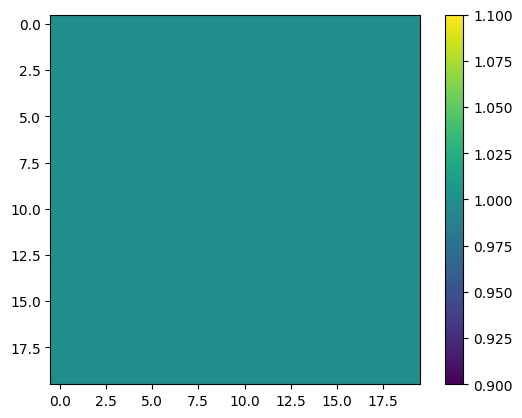

In [26]:
print_lattice(lattice)

In [9]:
convolving_window = generate_binary_structure(2,1)
convolving_window

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]])

In [10]:
def get_energy(lattice_mat):
    convolving_window = generate_binary_structure(2,2)
    convolving_window[1][1] = False
    arr = -lattice_mat * convolve(lattice_mat,convolving_window,mode = "constant",cval = 0)
    return arr.sum()
    

In [11]:
print(f"Energy of +ve lattice = {get_energy(lattice)}")

Energy of +ve lattice = -2964.0


In [25]:
# print(f"Energy of +ve lattice = {get_energy(lattice_p)}")
# print(f"Energy of -ve lattice = {get_energy(lattice_n)}")

In [43]:
@numba.njit("UniTuple(f8[:],2)(f8[:,:],i8,f8,f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, beta_J, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    
    for t in range(0, times-1):
        x = np.random.randint(0, N)
        y = np.random.randint(0, N)

        spin_i = spin_arr[x, y]
        spin_f = spin_i * -1

        Init_energy = 0
        Fin_energy = 0

        if x > 0:
            Init_energy += -spin_i * spin_arr[x-1, y]
            Fin_energy += -spin_f * spin_arr[x-1, y]
        if x < N-1:
            Init_energy += -spin_i * spin_arr[x+1, y]
            Fin_energy += -spin_f * spin_arr[x+1, y]
        if y > 0:
            Init_energy += -spin_i * spin_arr[x, y-1]
            Fin_energy += -spin_f * spin_arr[x, y-1]
        if y < N-1:
            Init_energy += -spin_i * spin_arr[x, y+1]
            Fin_energy += -spin_f * spin_arr[x, y+1]

        dE = Fin_energy - Init_energy

        if (dE > 0) * (np.random.random() < np.exp(-beta_J * dE)):
            spin_arr[x, y] = spin_f
            energy += dE
        elif dE <= 0:
            spin_arr[x, y] = spin_f
            energy += dE

        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy

    return net_spins, net_energy


/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [44]:
spin,energies = metropolis(lattice,1000000,0.2,get_energy(lattice))

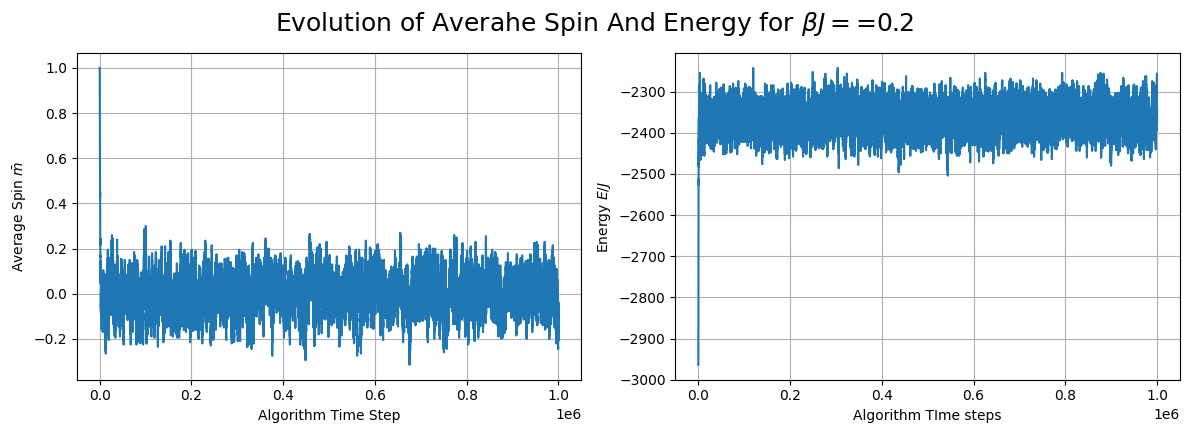

In [45]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
ax = axes[0]
ax.plot(spin/N**2)
ax.set_xlabel('Algorithm Time Step')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm TIme steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Averahe Spin And Energy for $\beta J=$=0.2',y = 1.07,size = 18)
plt.show()

In [48]:

def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    ms_stds = np.zeros(len(BJs))
    
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(lattice, 1000000, bj, get_energy(lattice))
        ms[i] = spins[-100000:].mean()/N**2
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
        ms_stds[i] = spins[-100000:].std()
    return ms, ms_stds,E_means, E_stds
    
BJs = np.arange(0.1, 2, 0.05)
ms, ms_stds,E_means, E_stds = get_spin_energy(lattice, BJs)
# ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)



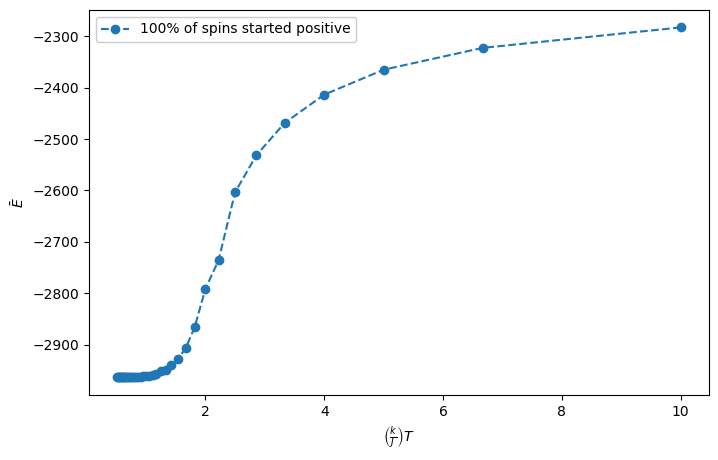

In [57]:

plt.figure(figsize=(8,5))
# plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, E_means, 'o--', label='100% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{E}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

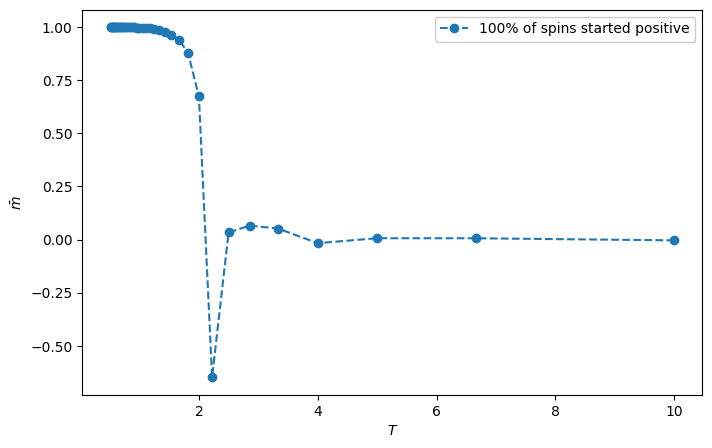

In [53]:


plt.figure(figsize=(8,5))
# plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms, 'o--', label='100% of spins started positive')
plt.xlabel(r'$T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()



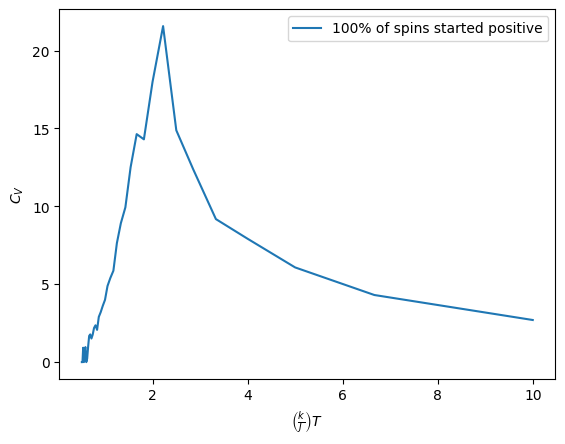

In [56]:


# plt.plot(1/BJs, E_stds_n*BJs, label='75% of spins started negative')
plt.plot(1/BJs, E_stds*BJs, label='100% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V$')
plt.legend()
plt.show()



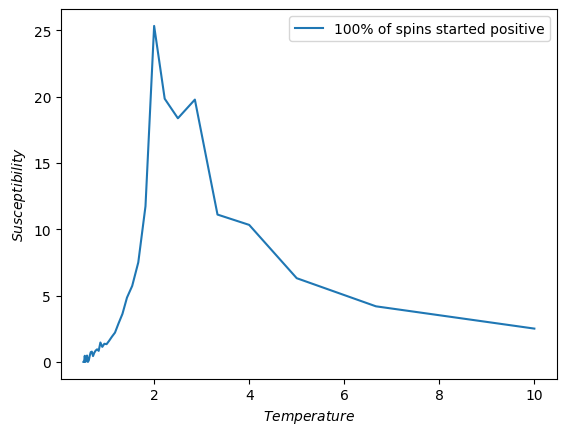

In [52]:
plt.plot(1/BJs, ms_stds*BJs, label='100% of spins started positive')
plt.xlabel(r'$Temperature$')
plt.ylabel(r'$Susceptibility$')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_spins(N):
    return 2 * np.pi * np.random.rand(N, N)

def plot_spins(spins):
    plt.figure(figsize=(4,4))
    plt.pcolor(np.cos(spins), cmap='YlOrRd_r')
    plt.colorbar()
    plt.title('XY Model Simulation')
    
    plt.show()

def metropolis_update(spins, beta):
    N = spins.shape[0]
    i, j = np.random.randint(0, N, size=2)
    delta_theta = np.random.uniform(-np.pi, np.pi)
    
    current_energy = -np.cos(spins[i, j] - spins[(i+1)%N, j]) - np.cos(spins[i, j] - spins[i, (j+1)%N])
    proposed_energy = -np.cos((spins[i, j] + delta_theta) - spins[(i+1)%N, j]) - np.cos((spins[i, j] + delta_theta) - spins[i, (j+1)%N])
    
    if np.random.rand() < np.exp(-beta * (proposed_energy - current_energy)):
        spins[i, j] += delta_theta

def run_simulation(N, temperature, num_steps):
    spins = initialize_spins(N)
    beta = 1 / temperature
    plot_spins(spins)
    for step in range(num_steps):
        metropolis_update(spins, beta)

    return spins



if __name__ == "__main__":
    N = 25  # Grid size
    temperature = 0.1  # Temperature of the system
    num_steps = 100000  # Number of Metropolis steps

    final_spins = run_simulation(N, temperature, num_steps)
    plot_spins(final_spins)


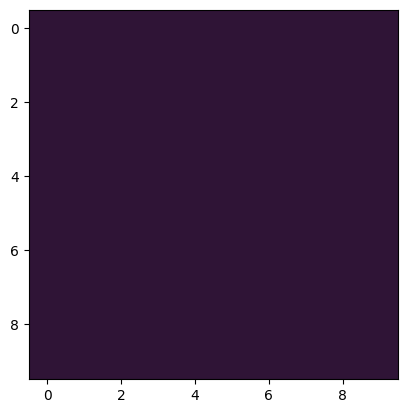

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Parameters
L = 10  # Size of the lattice
J = 1.0  # Coupling constant
temperature = 2.0  # Temperature

# Initialize spins randomly
spins = np.random.rand(L, L) * 2 * np.pi

# Function to calculate the change in energy
def delta_energy(spin, neighbors):
    return 2 * J * np.sum(np.cos(spin - neighbors))

# Function to perform the Metropolis update
def metropolis_update(spin, neighbors, temperature):
    dE = delta_energy(spin, neighbors)
    if dE < 0 or np.random.rand() < np.exp(-dE / temperature):
        return spin + np.random.uniform(-np.pi, np.pi)
    else:
        return spin

# Function to update the lattice using Metropolis updates
def update_lattice(spins, temperature):
    for i in range(L):
        for j in range(L):
            neighbors = spins[(i - 1) % L, j] + spins[(i + 1) % L, j] + spins[i, (j - 1) % L] + spins[i, (j + 1) % L]
            spins[i, j] = metropolis_update(spins[i, j], neighbors, temperature)

# Function to initialize the plot
def init():
    im.set_array(np.zeros((L, L)))
    return im,

# Function to update the plot
def update(frame):
    update_lattice(spins, temperature)
    im.set_array(np.cos(spins))  # Display the cosine of spins for visualization
    return im,

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(np.cos(spins), cmap='twilight', vmin=-1, vmax=1, animated=True)

# Set up animation
ani = FuncAnimation(fig, update, frames=200, init_func=init, blit=True)

# Show the plot
plt.show()

In [15]:
pip install --upgrade matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/19/e5/a4ea514515f270224435c69359abb7a3d152ed31b9ee3ba5e63017461945/matplotlib-3.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 69.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.4
    Uninstalling matplotlib-3.7.4:
      Successfully uninstalled matplotlib-3.7.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.814.150030 requires jupyter-server~=1.16, but you have jupyter-server 2.12.1 which is incompatible.
beatrix-jupyterlab 2023.814.150030 requires jupyterlab~=3.4, but you have jupyterlab 4.0.5 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.24.3 which is in

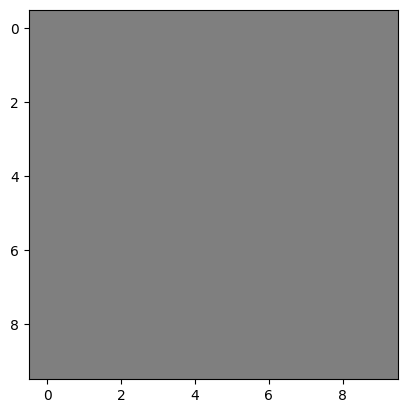

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Parameters
L = 10  # Size of the lattice
J = 1.0  # Coupling constant
temperature = 2.0  # Temperature

# Initialize spins randomly (+1 or -1)
spins = np.random.choice([-1, 1], size=(L, L))

# Function to calculate the change in energy
def delta_energy(spin, neighbors):
    return 2 * J * spin * np.sum(neighbors)

# Function to perform the Metropolis update
def metropolis_update(spin, neighbors, temperature):
    dE = delta_energy(spin, neighbors)
    if dE < 0 or np.random.rand() < np.exp(-dE / temperature):
        return -spin  # Flip the spin
    else:
        return spin

# Function to update the lattice using Metropolis updates
def update_lattice(spins, temperature):
    for i in range(L):
        for j in range(L):
            neighbors = spins[(i - 1) % L, j] + spins[(i + 1) % L, j] + spins[i, (j - 1) % L] + spins[i, (j + 1) % L]
            spins[i, j] = metropolis_update(spins[i, j], neighbors, temperature)

# Function to initialize the plot
def init():
    im.set_array(np.zeros((L, L)))
    return im,

# Function to update the plot
def update(frame):
    update_lattice(spins, temperature)
    im.set_array(spins)
    return im,

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(spins, cmap='binary', animated=True)

# Set up animation
ani = FuncAnimation(fig, update, frames=200, init_func=init, blit=True)

# Show the plot
plt.show()